# HW06: Python 
(due November 3rd)

# Heterogeneous Treatment Effects with Keras MLP

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Dataset on RCT study of case management on mental health outcomes

# show variable labels
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta', iterator=True).variable_labels()

{'trialid': 'Trial ID',
 'centreid': 'Trial centre',
 'status': 'Patient status at baseline',
 'age': 'Age in years at baseline',
 'sex': 'Sex',
 'afcarib': 'Ethnic group',
 'ocfabth': "Father's social class at birth",
 'chron1l': 'Months since onset of psychosis, logged',
 'hos94': 'Days in hospital for psychiatric reasons: 2 years before baseline',
 'cprs94': 'Psychopathology at baseline (CPRS)',
 'das94': 'Disability at baseline (DAS)',
 'sat94': '(Dis)satisfaction with services at baseline',
 'rand': 'Randomised group',
 'hos96': 'Days in hospital for psychiatric reasons: 2 years after baseline',
 'cprs96': 'Psychopathology at 2 years (CPRS)',
 'sat96': '(Dis)satisfaction with services at 2 years'}

In [3]:
# Load data 
df = pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   trialid   500 non-null    float64 
 1   centreid  500 non-null    category
 2   status    500 non-null    category
 3   age       500 non-null    float64 
 4   sex       500 non-null    category
 5   afcarib   500 non-null    category
 6   ocfabth   413 non-null    category
 7   chron1l   500 non-null    float32 
 8   hos94     500 non-null    float64 
 9   cprs94    500 non-null    float64 
 10  das94     489 non-null    float64 
 11  sat94     399 non-null    float64 
 12  rand      500 non-null    category
 13  hos96     477 non-null    float64 
 14  cprs96    421 non-null    float64 
 15  sat96     349 non-null    float64 
dtypes: category(6), float32(1), float64(9)
memory usage: 44.7 KB


In [4]:
# the post-treatment outcomes to analyze
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()

,sat96,hos96,cprs96
count,349.000000,477.000000,421.000000
mean,17.102794,72.463312,18.624924
std,4.730995,113.007423,13.583216
min,9.000000,0.000000,0.000000
25%,13.500000,0.000000,8.000000
50%,17.000000,22.000000,16.000000
75%,20.000000,98.000000,27.000000
max,32.000000,725.000000,71.000000


In [5]:
# variable describing treatment status
treatvar = 'rand'
df[treatvar].value_counts()

Intensive case management    251
Standard case management     249
Name: rand, dtype: int64

In [6]:
df.head()

,trialid,centreid,status,age,sex,afcarib,ocfabth,chron1l,hos94,cprs94,das94,sat94,rand,hos96,cprs96,sat96
0,222064.0,St Mary's,In hospital,59.0,male,Other,B,6.011267,13.0,12.0,1.285714,20.0,Standard case management,32.0,47.0,NaN
1,107.0,St George's,Out-patient,27.0,male,Other,A,3.178054,80.0,4.0,0.285714,18.0,Intensive case management,27.0,3.0,22.000
2,222005.0,St Mary's,In hospital,41.0,male,Other,D,4.521789,240.0,6.0,0.750000,15.0,Intensive case management,15.0,13.0,9.000
3,222018.0,St Mary's,In hospital,25.0,male,Other,C2,4.094345,48.0,12.0,0.125000,18.0,Intensive case management,263.0,6.0,21.375
4,222049.0,St Mary's,In hospital,50.0,female,Other,C2,5.817111,63.0,25.0,0.500000,20.0,Standard case management,5.0,8.0,NaN


In [7]:
df = df.dropna()

float64var = ['trialid', 'age',  'hos94', 'cprs94', 'das94', 'sat94', 'hos96', 'cprs96', 'sat96']
catvar = ['centreid', 'status', 'sex', 'afcarib', 'ocfabth']

df['centreid'] = df['centreid'].astype('category').cat.codes
df['status'] = df['status'].astype('category').cat.codes
df['sex'] = df['sex'].astype('category').cat.codes
df['afcarib'] = df['afcarib'].astype('category').cat.codes
df['ocfabth'] = df['ocfabth'].astype('category').cat.codes

df.head()

,trialid,centreid,status,age,sex,afcarib,ocfabth,chron1l,hos94,cprs94,das94,sat94,rand,hos96,cprs96,sat96
1,107.0,0,0,27.0,0,0,0,3.178054,80.0,4.0,0.285714,18.0,Intensive case management,27.0,3.0,22.000
2,222005.0,2,1,41.0,0,0,4,4.521789,240.0,6.0,0.750000,15.0,Intensive case management,15.0,13.0,9.000
3,222018.0,2,1,25.0,0,0,3,4.094345,48.0,12.0,0.125000,18.0,Intensive case management,263.0,6.0,21.375
5,312015.0,3,0,31.0,1,0,0,4.787492,60.0,28.0,2.375000,20.0,Intensive case management,45.0,19.0,17.000
6,221023.0,2,1,35.0,0,1,3,4.430817,60.0,25.0,1.571428,24.0,Intensive case management,58.0,27.0,19.125


In [8]:
# covariates for predicting the outcome conditional on treatment
covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']
df[covariates].describe()

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,0.394309,0.455285,18.837907,2.715447,94.776423,1.072794,19.362691,38.593496,0.276423
std,0.489698,0.499012,4.907599,1.188519,94.375038,0.820939,13.350190,11.050044,0.448140
min,0.000000,0.000000,9.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000
25%,0.000000,0.000000,15.750000,2.000000,33.250000,0.428571,9.000000,30.000000,0.000000
50%,0.000000,0.000000,19.000000,3.000000,63.000000,1.000000,17.000000,36.000000,0.000000
75%,1.000000,1.000000,22.000000,4.000000,126.000000,1.500000,27.000000,47.000000,1.000000
max,1.000000,1.000000,36.000000,5.000000,730.000000,4.714283,67.000000,65.000000,1.000000


In [9]:
# Subset the dataset by treatment (intensive) and control (standard)
df_treat = df[df[treatvar] == 'Intensive case management']
df_control = df[df[treatvar] == 'Standard case management']


In [10]:
# build an MLP model with at least 2 hidden layers, ReLU activation, batch normalization, dropout
model_tr = keras.models.Sequential(name = "Treatment")

model_tr.add(keras.layers.BatchNormalization())
model_tr.add(keras.layers.Dense(input_dim=len(covariates),units=256, activation="relu"))
model_tr.add(keras.layers.Dropout(0.2))
model_tr.add(keras.layers.Dense(128, activation="relu"))
model_tr.add(keras.layers.Dense(1))

In [11]:
model_cn = keras.models.Sequential(name = "Control")

model_cn.add(keras.layers.BatchNormalization())
model_cn.add(keras.layers.Dense(input_dim=len(covariates),units=128, activation="relu"))
model_cn.add(keras.layers.Dropout(0.2))
model_cn.add(keras.layers.Dense(64, activation="relu"))
model_cn.add(keras.layers.Dense(1))

In [12]:
# compile the model
model_tr.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.Adam(),
              metrics="mean_squared_error")
model_cn.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.Adam(),
              metrics="mean_squared_error")

In [13]:
# choose one of the three outcomes to analyze.
# fit separate models on the treatment dataset and control dataset
# use early stopping

X_treat = df_treat[covariates]
X_control = df_control[covariates]

y_treat = df_treat['cprs96']
y_control = df_control['cprs96']

X_tr_val_train, X_tr_test, y_tr_val_train, y_tr_test = train_test_split(X_treat, y_treat)
X_cn_val_train, X_cn_test, y_cn_val_train, y_cn_test = train_test_split(X_control, y_control)

X_tr_train, X_tr_val, y_tr_train, y_tr_val = train_test_split(X_tr_val_train, y_tr_val_train)
X_cn_train, X_cn_val, y_cn_train, y_cn_val = train_test_split(X_cn_val_train, y_cn_val_train)

earlystop = EarlyStopping(monitor='loss', patience=10)

tr_model = model_tr.fit(X_tr_train, y_tr_train, epochs=512,
                    validation_data=(X_tr_val, y_tr_val), callbacks=[earlystop], verbose=0)
cn_model = model_cn.fit(X_cn_train, y_cn_train, epochs=512,
                    validation_data=(X_cn_val, y_cn_val), callbacks=[earlystop], verbose=0)

print(len(tr_model.history['val_loss']))
print(len(cn_model.history['val_loss']))
print(tr_model.history['val_loss'])
print(cn_model.history['val_loss'])

model_tr.summary()
model_cn.summary()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

48
56
[441.64453

MSE y tr -> tr:                154.7
R2  y tr -> tr:                0.104
MSE y tr -> cn:                163.4
R2  y tr -> cn:              -0.1634
MSE y cn -> cn:                229.9
R2  y cn -> cn:              -0.6371
MSE y cn -> tr:                211.9
R2  y cn -> tr:              -0.2271


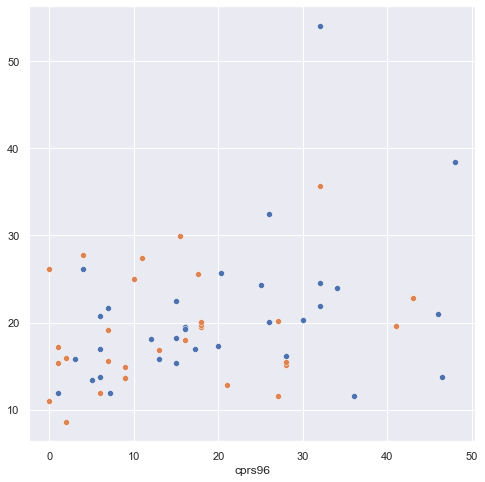

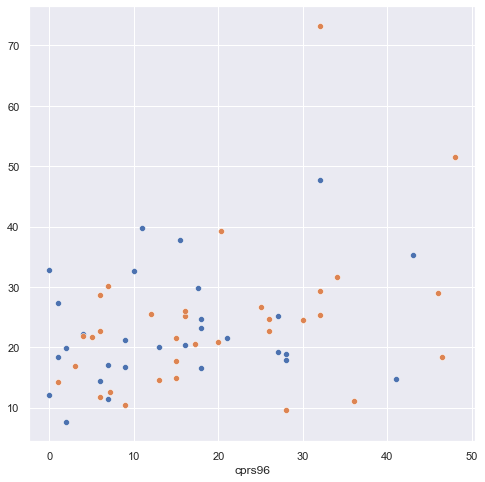

In [14]:
# form predicted outcomes for each individual, for both control and treatment
y_tr_pred = model_tr.predict(X_tr_test)
y_tr_pred_cn = model_tr.predict(X_cn_test)
y_cn_pred = model_cn.predict(X_cn_test)
y_cn_pred_tr = model_cn.predict(X_tr_test)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.figure(figsize=(8,8))
sns.scatterplot(x=y_tr_test, y=y_tr_pred.reshape(1,-1)[0])
sns.scatterplot(x=y_cn_test, y=y_tr_pred_cn.reshape(1,-1)[0])
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_cn_test, y=y_cn_pred.reshape(1,-1)[0])
sns.scatterplot(x=y_tr_test, y=y_cn_pred_tr.reshape(1,-1)[0])

from sklearn.metrics import mean_squared_error, r2_score

mse_y_tr_tr = mean_squared_error(y_tr_test, y_tr_pred.reshape(1,-1)[0])
r2_y_tr_tr = r2_score(y_tr_test, y_tr_pred.reshape(1,-1)[0])

mse_y_tr_cn = mean_squared_error(y_cn_test, y_tr_pred_cn.reshape(1,-1)[0])
r2_y_tr_cn = r2_score(y_cn_test, y_tr_pred_cn.reshape(1,-1)[0])

mse_y_cn_cn = mean_squared_error(y_cn_test, y_cn_pred.reshape(1,-1)[0])
r2_y_cn_cn = r2_score(y_cn_test, y_cn_pred.reshape(1,-1)[0])

mse_y_cn_tr = mean_squared_error(y_tr_test, y_cn_pred_tr.reshape(1,-1)[0])
r2_y_cn_tr = r2_score(y_tr_test, y_cn_pred_tr.reshape(1,-1)[0])

print("MSE y tr -> tr:           {:>10.4}".format(mse_y_tr_tr))
print("R2  y tr -> tr:           {:>10.4}".format(r2_y_tr_tr))

print("MSE y tr -> cn:           {:>10.4}".format(mse_y_tr_cn))
print("R2  y tr -> cn:           {:>10.4}".format(r2_y_tr_cn))

print("MSE y cn -> cn:           {:>10.4}".format(mse_y_cn_cn))
print("R2  y cn -> cn:           {:>10.4}".format(r2_y_cn_cn))

print("MSE y cn -> tr:           {:>10.4}".format(mse_y_cn_tr))
print("R2  y cn -> tr:           {:>10.4}".format(r2_y_cn_tr))

In [15]:
# explore what features matter for the predicted difference between control and treatment

covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']

model_feat = [0 for i in range(len(covariates))]
model_feat2 = [0 for i in range(len(covariates))]

model_feat_loss = [0 for i in range(len(covariates))]
model_feat2_loss = [0 for i in range(len(covariates))]

for i, column in enumerate(covariates):

    model_feat[i] = keras.models.Sequential()

    model_feat[i].add(keras.layers.BatchNormalization())
    model_feat[i].add(keras.layers.Dense(input_dim=len(covariates)-1,units=256, activation="relu"))
    model_feat[i].add(keras.layers.Dropout(0.2))
    model_feat[i].add(keras.layers.Dense(128, activation="relu"))
    model_feat[i].add(keras.layers.Dense(1))

    model_feat[i].compile(loss="mean_squared_error",
                  optimizer=keras.optimizers.Adam(),
                  metrics="mean_squared_error")
    
    model_feat2[i] = keras.models.Sequential()

    model_feat2[i].add(keras.layers.BatchNormalization())
    model_feat2[i].add(keras.layers.Dense(input_dim=len(covariates)-1,units=256, activation="relu"))
    model_feat2[i].add(keras.layers.Dropout(0.2))
    model_feat2[i].add(keras.layers.Dense(128, activation="relu"))
    model_feat2[i].add(keras.layers.Dense(1))

    model_feat2[i].compile(loss="mean_squared_error",
                  optimizer=keras.optimizers.Adam(),
                  metrics="mean_squared_error")
    
    tr_model_feat = model_feat[i].fit(X_tr_train.drop(covariates[i], axis=1), y_tr_train, epochs=64,
                        validation_data=(X_tr_val.drop(covariates[i], axis=1), y_tr_val), callbacks=[earlystop], verbose=0)
    cn_model_feat = model_feat2[i].fit(X_cn_train.drop(covariates[i], axis=1), y_cn_train, epochs=64,
                        validation_data=(X_cn_val.drop(covariates[i], axis=1), y_cn_val), callbacks=[earlystop], verbose=0)
    
    model_feat_loss[i] = min(tr_model_feat.history['val_loss'])
    model_feat2_loss[i] =min(cn_model_feat.history['val_loss'])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

In [16]:
for i, column in enumerate(covariates):
    print("treatment w/o {:>10}: {:>10.3}".format(covariates[i], model_feat_loss[i]))
    print("control w/o   {:>10}: {:>10.3}".format(covariates[i], model_feat2_loss[i]))

treatment w/o     status:   2.44e+02
control w/o       status:   2.35e+02
treatment w/o        sex:   2.39e+02
control w/o          sex:   2.42e+02
treatment w/o      sat94:   2.16e+02
control w/o        sat94:   2.37e+02
treatment w/o    ocfabth:   2.25e+02
control w/o      ocfabth:   2.32e+02
treatment w/o      hos94:    2.5e+02
control w/o        hos94:    1.4e+02
treatment w/o      das94:   2.14e+02
control w/o        das94:   2.73e+02
treatment w/o     cprs94:   2.77e+02
control w/o       cprs94:   3.32e+02
treatment w/o        age:   2.29e+02
control w/o          age:    2.8e+02
treatment w/o    afcarib:   2.32e+02
control w/o      afcarib:    2.5e+02
